In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import midii
import copy
from pathlib import Path

In [2]:
def plot_piano_roll(ax, notes, unit_ticks, TPQN, title, height=1):
    """Plots notes on a piano roll axes."""
    ax.set_title(title)
    ax.set_xlabel("Time (ticks)")
    ax.set_ylabel("Pitch")
    min_pitch = min(n["pitch"] for n in notes) - 2 if notes else 58
    max_pitch = max(n["pitch"] for n in notes) + 2 if notes else 74
    max_time = max(n["end"] for n in notes) if notes else TPQN * 4
    ax.set_ylim(min_pitch, max_pitch)
    ax.set_xlim(0, max_time)

    for note in notes:
        # Use patches.Rectangle for notes
        rect = patches.Rectangle(
            (note["start"], note["pitch"] - 0.5),  # (x, y) bottom-left corner
            note["duration"],  # width (duration)
            height,  # height
            linewidth=1,
            edgecolor="k",
            facecolor="skyblue",
        )
        ax.add_patch(rect)

    # Add grid lines
    if unit_ticks:
        major_ticks = np.arange(0, max_time + unit_ticks, unit_ticks)
        ax.set_xticks(major_ticks)
        ax.grid(which="major", axis="x", linestyle="--")
    else:  # Finer grid for original
        major_ticks = np.arange(
            0, max_time + TPQN // 4, TPQN // 4
        )  # 16th notes
        minor_ticks = np.arange(
            0, max_time + TPQN // 8, TPQN // 8
        )  # 32nd notes
        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.grid(which="minor", axis="x", linestyle=":", alpha=0.7)
        ax.grid(which="major", axis="x", linestyle="--")

    ax.set_yticks(
        np.arange(min_pitch, max_pitch, 2)
    )  # Adjust y-ticks as needed

In [3]:
def normalize(json):
    offset = json[0]["start"]
    for note in json:
        note["start"] -= offset
        note["end"] -= offset
    return json

In [4]:
mid = midii.MidiFile(
    midii.sample.dataset[0], convert_1_to_0=True, lyric_encoding="cp949"
)
Path(mid.filename).name

'ba_05688_-4_a_s02_m_02.mid'

unit 15


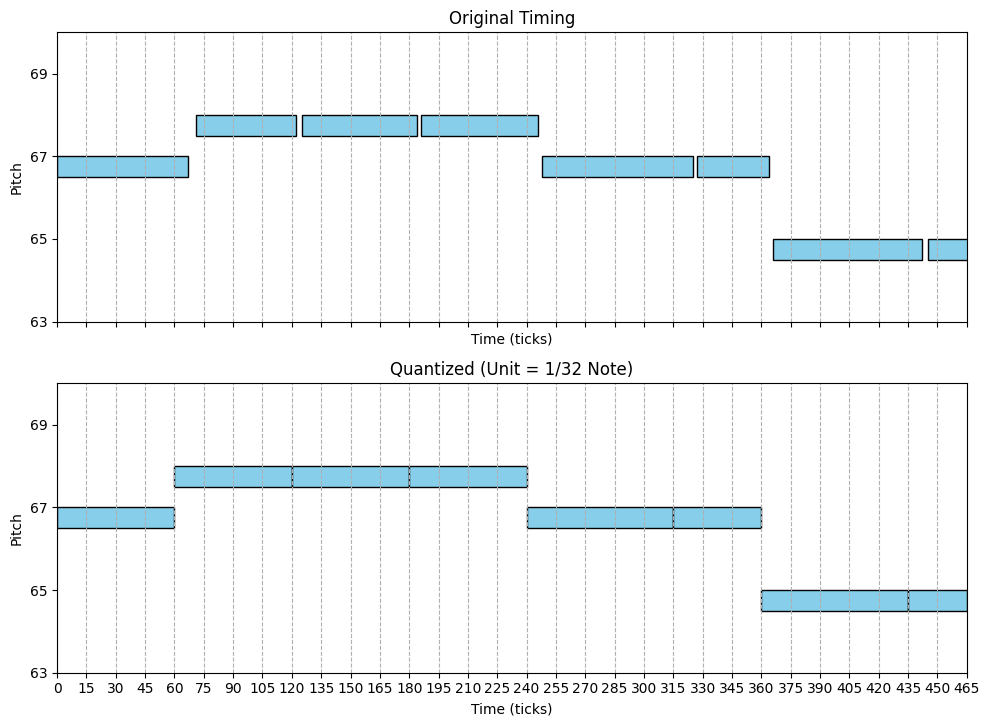

In [5]:
mid_q32 = copy.deepcopy(mid)
mid_q32.quantize(unit="32")

dataset = [
    normalize(mid.to_json()[4:12]),
    normalize(mid_q32.to_json()[4:12]),
]

subset = slice(0, 13, 1)
limit = len(dataset)
height = 0.5

fig1, axs1 = plt.subplots(limit, 1, figsize=(10, 8), sharex=True)
# fig1.suptitle(
#     "Figure 1: Piano Roll Visualization of Quantization Effects",
#     fontsize=14,
# )
plot_piano_roll(
    axs1[0],
    dataset[0][subset],
    mid.ticks_per_beat,
    mid.ticks_per_beat,
    "Original Timing",
    height=height
)
plot_piano_roll(
    axs1[1],
    dataset[1][subset],
    mid.ticks_per_beat / 8,
    mid.ticks_per_beat,
    "Quantized (Unit = 1/32 Note)",
    height=height
)
plt.tight_layout(
    rect=[0, 0.03, 1, 0.95]
)  
plt.savefig("../figure/figure_piano_roll.pdf", format="pdf", bbox_inches='tight') 
plt.savefig("../figure/figure_piano_roll.png", format="png", bbox_inches='tight') 
# plt.show()  

In [6]:
print(f"Unit Note(15 ticks n/32) Division Mean={np.mean(np.array(mid.times) % 15):.2f}")
print(f"Unit Note(15 ticks n/32) Division Mean={np.mean(np.array(mid_q32.times) % 15)}")

Unit Note(15 ticks n/32) Division Mean=3.42
Unit Note(15 ticks n/32) Division Mean=0.0


In [7]:
print(f"Unit Note(15 ticks n/32) Division Mean={np.mean([x['start'] % 15 + x['end'] % 15 for x in mid.to_json()]):.2f}")
print(f"Unit Note(15 ticks n/32) Division Mean={np.mean([x['start'] % 15 + x['end'] % 15 for x in mid_q32.to_json()])}")

Unit Note(15 ticks n/32) Division Mean=15.05
Unit Note(15 ticks n/32) Division Mean=0.0


In [8]:
def mean_grid_alignment_error(items, unit_beat_ticks):
    total_error = 0
    for x in items:
        error = x['end'] % unit_beat_ticks
        if error < unit_beat_ticks/2:
            total_error += error
        else:
            total_error += unit_beat_ticks - error
        error = x['start'] % unit_beat_ticks
        if error < unit_beat_ticks/2:
            total_error += error
        else:
            total_error += unit_beat_ticks - error
    return total_error/len(items)

In [9]:

print(f"Mean Grid Alignment Error={mean_grid_alignment_error(mid.to_json(), 15):.3f}")
print(f"Mean Grid Alignment Error={mean_grid_alignment_error(mid_q32.to_json(), 15)}")

Mean Grid Alignment Error=7.676
Mean Grid Alignment Error=0.0
